In [2]:
import torch
from torch import nn
import torch.nn.functional as F
import math
from transformer import MultiHeadAttention, LayerNorm, FeedForward, PositionalEncoding, EncoderLayer
import matplotlib.pyplot as plt
import numpy as np

In [3]:
class PatchEmbedding(nn.Module):
    def __init__(self, img_size=224, patch_size=16, in_channels=3, embed_dim=768):
        super().__init__()
        self.img_size = img_size
        self.patch_size = patch_size
        self.n_patches = (img_size // patch_size) ** 2
        
        # 使用卷积层进行patch embedding
        self.patch_embed = nn.Conv2d(
            in_channels, embed_dim, 
            kernel_size=patch_size, 
            stride=patch_size
        )
        
    def forward(self, x):
        # x shape: (batch_size, in_channels, img_size, img_size)
        x = self.patch_embed(x)  # (batch_size, embed_dim, n_patches**0.5, n_patches**0.5)
        x = x.flatten(2)         # (batch_size, embed_dim, n_patches)
        x = x.transpose(1, 2)    # (batch_size, n_patches, embed_dim)
        return x

In [4]:
class ViTEmbedding(nn.Module):
    def __init__(self, img_size=224, patch_size=16, in_channels=3, embed_dim=768, dropout=0.1):
        super().__init__()
        self.patch_embedding = PatchEmbedding(img_size, patch_size, in_channels, embed_dim)
        self.cls_token = nn.Parameter(torch.zeros(1, 1, embed_dim))
        # 使用transformer模块中的PositionalEncoding
        self.pos_encoding = PositionalEncoding(embed_dim, max_len=(img_size // patch_size) ** 2 + 1)
        self.dropout = nn.Dropout(dropout)
        
        # 初始化cls_token
        nn.init.trunc_normal_(self.cls_token, std=0.02)

    def forward(self, x):
        # x shape: (batch_size, channels, height, width)
        batch_size = x.shape[0]
        
        # Patch embedding
        x = self.patch_embedding(x)  # (batch_size, n_patches, embed_dim)
        
        # 添加cls token
        cls_tokens = self.cls_token.expand(batch_size, -1, -1)  # (batch_size, 1, embed_dim)
        x = torch.cat([cls_tokens, x], dim=1)  # (batch_size, n_patches+1, embed_dim)
        
        # 添加位置编码
        x = self.pos_encoding(x)
        x = self.dropout(x)
        
        return x

In [5]:
class VisionTransformer(nn.Module):
    def __init__(self, 
                 img_size=224, 
                 patch_size=16, 
                 in_channels=3, 
                 embed_dim=768, 
                 num_layers=12, 
                 num_heads=12, 
                 mlp_ratio=4, 
                 num_classes=1000, 
                 dropout=0.1):
        super().__init__()
        
        # Embedding layer
        self.embedding = ViTEmbedding(img_size, patch_size, in_channels, embed_dim, dropout)
        
        # Transformer encoder layers - 使用标准的 EncoderLayer
        hidden_dim = embed_dim * mlp_ratio
        self.encoder_layers = nn.ModuleList([
            EncoderLayer(embed_dim, num_heads, hidden_dim, dropout) 
            for _ in range(num_layers)
        ])
        
        # Classification head
        self.norm = LayerNorm(embed_dim)
        self.head = nn.Linear(embed_dim, num_classes)
        
        # 初始化权重
        self.apply(self._init_weights)

    def _init_weights(self, m):
        if isinstance(m, nn.Linear):
            nn.init.trunc_normal_(m.weight, std=0.02)
            if m.bias is not None:
                nn.init.constant_(m.bias, 0)
        elif isinstance(m, nn.LayerNorm):
            nn.init.constant_(m.bias, 0)
            nn.init.constant_(m.weight, 1.0)

    def forward(self, x):
        # Embedding
        x = self.embedding(x)  # (batch_size, n_patches+1, embed_dim)
        
        # Transformer encoder
        for layer in self.encoder_layers:
            x = layer(x)
        
        # Final normalization
        x = self.norm(x)
        
        # Classification - use cls token
        cls_token = x[:, 0]  # (batch_size, embed_dim)
        logits = self.head(cls_token)  # (batch_size, num_classes)
        
        return logits

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-4.6174884..4.9287686].
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-4.6174884..4.9287686].
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-4.6174884..4.9287686].


原始图像形状: torch.Size([1, 3, 224, 224])
Patch embedding形状: torch.Size([1, 196, 768])
每个图像被分割成 196 个patches
每个patch被投影到 768 维向量


/var/folders/sb/4jn24bvx6bn9_1_r9gzf38lw0000gn/T/ipykernel_99090/2708619783.py:50: UserWarning: Glyph 21407 (\N{CJK UNIFIED IDEOGRAPH-539F}) missing from font(s) DejaVu Sans.
  plt.tight_layout()
/var/folders/sb/4jn24bvx6bn9_1_r9gzf38lw0000gn/T/ipykernel_99090/2708619783.py:50: UserWarning: Glyph 22987 (\N{CJK UNIFIED IDEOGRAPH-59CB}) missing from font(s) DejaVu Sans.
  plt.tight_layout()
/var/folders/sb/4jn24bvx6bn9_1_r9gzf38lw0000gn/T/ipykernel_99090/2708619783.py:50: UserWarning: Glyph 22270 (\N{CJK UNIFIED IDEOGRAPH-56FE}) missing from font(s) DejaVu Sans.
  plt.tight_layout()
/var/folders/sb/4jn24bvx6bn9_1_r9gzf38lw0000gn/T/ipykernel_99090/2708619783.py:50: UserWarning: Glyph 20687 (\N{CJK UNIFIED IDEOGRAPH-50CF}) missing from font(s) DejaVu Sans.
  plt.tight_layout()
/var/folders/sb/4jn24bvx6bn9_1_r9gzf38lw0000gn/T/ipykernel_99090/2708619783.py:50: UserWarning: Glyph 36890 (\N{CJK UNIFIED IDEOGRAPH-901A}) missing from font(s) DejaVu Sans.
  plt.tight_layout()
/var/folders/sb/4jn2

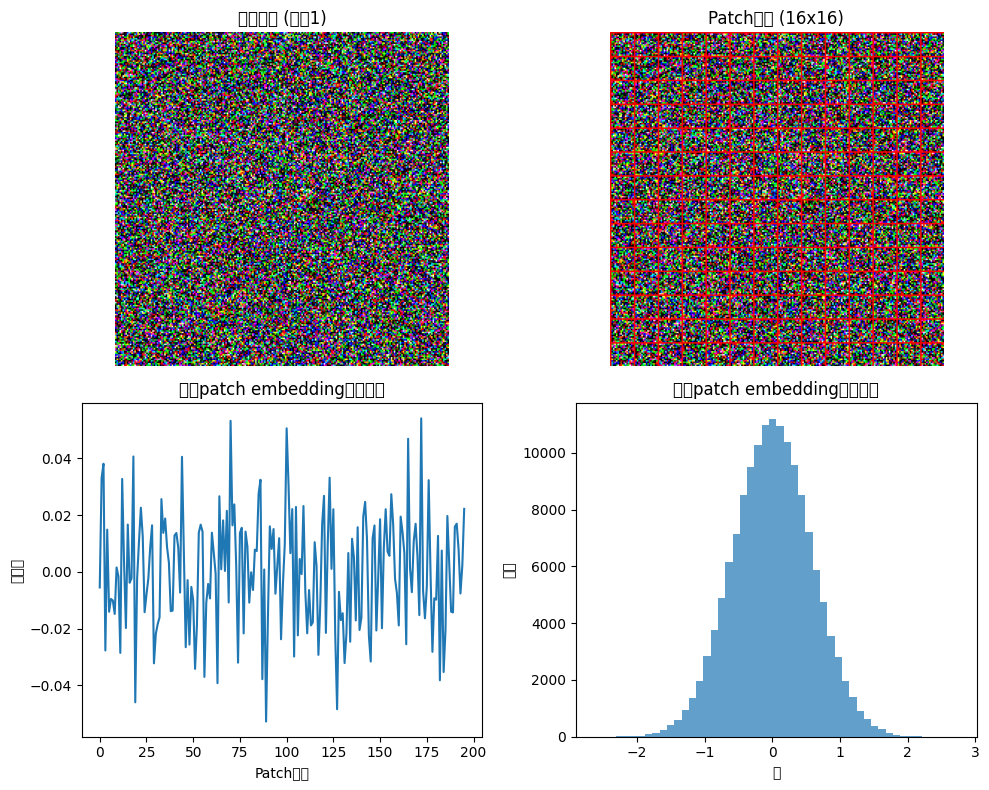

In [10]:
# 可视化patch embedding过程

def visualize_patches():
    # 创建一个随机图像作为输入
    img = torch.randn(1, 3, 224, 224)  # 假设输入是一个随机图像
    print(f"原始图像形状: {img.shape}")
    
    # 使用PatchEmbedding层
    patch_embed = PatchEmbedding(img_size=224, patch_size=16, in_channels=3, embed_dim=768)
    patches = patch_embed(img)
    
    print(f"Patch embedding形状: {patches.shape}")
    print(f"每个图像被分割成 {patches.size(1)} 个patches")
    print(f"每个patch被投影到 {patches.size(2)} 维向量")
    
    # 可视化原始图像和patch划分
    fig, axes = plt.subplots(2, 2, figsize=(10, 8))
    
    # 显示原始图像
    axes[0, 0].imshow(img[0].permute(1, 2, 0).detach().numpy())
    axes[0, 0].set_title('原始图像 (通道1)')
    axes[0, 0].axis('off')
    
    # 显示patch划分
    img_with_grid = img[0].permute(1, 2, 0).detach().numpy()
    for i in range(0, 224, 16):
        # 水平线
        img_with_grid[i:i+1, :, :] = [1, 0, 0]  # 红色
        # 垂直线
        img_with_grid[:, i:i+1, :] = [1, 0, 0]  # 红色
    
    axes[0, 1].imshow(img_with_grid)
    axes[0, 1].set_title('Patch划分 (16x16)')
    axes[0, 1].axis('off')
    
    # 显示patch embedding的统计信息
    patch_stats = patches[0].mean(dim=1).detach().numpy()  # 添加.detach()方法
    axes[1, 0].plot(patch_stats)
    axes[1, 0].set_title('每个patch embedding的平均值')
    axes[1, 0].set_xlabel('Patch索引')
    axes[1, 0].set_ylabel('平均值')
    
    # 显示patch embedding的直方图
    patch_flat = patches[0].reshape(-1).detach().numpy()  # 使用.reshape(-1)代替.view(-1)
    axes[1, 1].hist(patch_flat, bins=50, alpha=0.7)
    axes[1, 1].set_title('所有patch embedding值的分布')
    axes[1, 1].set_xlabel('值')
    axes[1, 1].set_ylabel('频次')
    
    plt.tight_layout()
    plt.show()
    
    return patches

# 运行可视化
patches = visualize_patches()

In [9]:
# MNIST数据集加载和预处理
from torchvision import transforms, datasets
from torch.utils.data import DataLoader

# 定义数据变换
transform = transforms.Compose([
    transforms.ToTensor(),
])

# 加载MNIST数据集
train_set = datasets.MNIST('../week 1/dataset/mnist/', train=True, transform=transform)
train_loader = DataLoader(train_set, batch_size=64, shuffle=True)
test_set = datasets.MNIST('../week 1/dataset/mnist/', train=False, transform=transform)
test_loader = DataLoader(test_set, batch_size=64, shuffle=False)

print(f"训练集大小: {len(train_set)}")
print(f"测试集大小: {len(test_set)}")
print(f"批次大小: 64")

训练集大小: 60000
测试集大小: 10000
批次大小: 64


In [15]:
# ViT模型训练
from tqdm import tqdm

# 使用MNIST版本的ViT
model = VisionTransformer(
    img_size=28,
    patch_size=7, 
    in_channels=1,
    embed_dim=64,
    num_layers=2,
    num_heads=4,
    mlp_ratio=4,
    num_classes=10,
    dropout=0.1
)

optimizer = torch.optim.Adam(model.parameters(), lr=0.001)
criterion = nn.CrossEntropyLoss()
epoch_num = 20

model.train()

print("开始训练ViT模型...")
for epoch in range(epoch_num):
    running_loss = 0.0
    for images, labels in tqdm(train_loader, desc=f'Epoch {epoch+1}/{epoch_num}'):
        optimizer.zero_grad()
        output = model(images)
        loss = criterion(output, labels)
        loss.backward()
        optimizer.step()
        
        running_loss += loss.item()
    
    avg_loss = running_loss / len(train_loader)
    print(f'Epoch {epoch+1}/{epoch_num}, 平均损失: {avg_loss:.4f}')

print("训练完成！")

开始训练ViT模型...


Epoch 1/20: 100%|██████████| 938/938 [00:15<00:00, 61.46it/s]


Epoch 1/20, 平均损失: 0.6854


Epoch 2/20: 100%|██████████| 938/938 [00:15<00:00, 62.26it/s]


Epoch 2/20, 平均损失: 0.2393


Epoch 3/20: 100%|██████████| 938/938 [00:15<00:00, 62.07it/s]


Epoch 3/20, 平均损失: 0.1870


Epoch 4/20: 100%|██████████| 938/938 [00:15<00:00, 61.25it/s]


Epoch 4/20, 平均损失: 0.1629


Epoch 5/20: 100%|██████████| 938/938 [00:15<00:00, 61.16it/s]


Epoch 5/20, 平均损失: 0.1464


Epoch 6/20: 100%|██████████| 938/938 [00:15<00:00, 60.57it/s]


Epoch 6/20, 平均损失: 0.1359


Epoch 7/20: 100%|██████████| 938/938 [00:15<00:00, 61.38it/s]



Epoch 7/20, 平均损失: 0.1257


Epoch 8/20: 100%|██████████| 938/938 [00:15<00:00, 61.01it/s]


Epoch 8/20, 平均损失: 0.1204


Epoch 9/20: 100%|██████████| 938/938 [00:15<00:00, 61.23it/s]


Epoch 9/20, 平均损失: 0.1100


Epoch 10/20: 100%|██████████| 938/938 [00:15<00:00, 60.15it/s]


Epoch 10/20, 平均损失: 0.1081


Epoch 11/20: 100%|██████████| 938/938 [00:15<00:00, 59.41it/s]


Epoch 11/20, 平均损失: 0.1007


Epoch 12/20: 100%|██████████| 938/938 [00:15<00:00, 60.40it/s]


Epoch 12/20, 平均损失: 0.0974


Epoch 13/20: 100%|██████████| 938/938 [00:15<00:00, 61.52it/s]


Epoch 13/20, 平均损失: 0.0949


Epoch 14/20: 100%|██████████| 938/938 [00:15<00:00, 60.68it/s]


Epoch 14/20, 平均损失: 0.0885


Epoch 15/20: 100%|██████████| 938/938 [00:15<00:00, 61.56it/s]


Epoch 15/20, 平均损失: 0.0860


Epoch 16/20: 100%|██████████| 938/938 [00:15<00:00, 61.56it/s]



Epoch 16/20, 平均损失: 0.0855


Epoch 17/20: 100%|██████████| 938/938 [00:15<00:00, 61.51it/s]


Epoch 17/20, 平均损失: 0.0810


Epoch 18/20: 100%|██████████| 938/938 [00:15<00:00, 60.82it/s]


Epoch 18/20, 平均损失: 0.0787


Epoch 19/20: 100%|██████████| 938/938 [00:15<00:00, 61.35it/s]


Epoch 19/20, 平均损失: 0.0789


Epoch 20/20: 100%|██████████| 938/938 [00:15<00:00, 61.64it/s]

Epoch 20/20, 平均损失: 0.0741
训练完成！


In [17]:
# 模型评估和指标计算
model.eval()
total_correct = 0
total = 0

num_classes = 10 # MNIST有10个类别 (0-9)
metrics_per_class = {i: {'TP': 0, 'FP': 0, 'TN': 0, 'FN': 0} for i in range(num_classes)}

with torch.no_grad():
    for images, labels in tqdm(test_loader, desc="测试模型"):
        output = model(images)
        _, predicted_class = torch.max(output.data, 1)

        for class_id in range(num_classes):
            # 将当前 class_id 视为"正类"
            is_positive_class = (labels == class_id)
            is_negative_class = (labels != class_id)

            # 模型预测为当前正类
            predicted_positive = (predicted_class == class_id)
            predicted_negative = (predicted_class != class_id)

            metrics_per_class[class_id]['TP'] += (predicted_positive & is_positive_class).sum().item()
            metrics_per_class[class_id]['FP'] += (predicted_positive & is_negative_class).sum().item()
            metrics_per_class[class_id]['TN'] += (predicted_negative & is_negative_class).sum().item()
            metrics_per_class[class_id]['FN'] += (predicted_negative & is_positive_class).sum().item()

        total += labels.size(0)
        total_correct += (predicted_class == labels).sum().item()

accuracy = 100 * total_correct / total
print(f'ViT模型准确率: {accuracy:.2f}%')

# 计算宏平均指标
precision_metrics = []
recall_metrics = []
f1_metrics = []

for class_id in range(num_classes):
    tp = metrics_per_class[class_id]['TP']
    fp = metrics_per_class[class_id]['FP']
    fn = metrics_per_class[class_id]['FN']
    
    precision = tp / (tp + fp) if (tp + fp) > 0 else 0
    recall = tp / (tp + fn) if (tp + fn) > 0 else 0
    f1 = 2 * (precision * recall) / (precision + recall) if (precision + recall) > 0 else 0
    
    precision_metrics.append(precision)
    recall_metrics.append(recall)
    f1_metrics.append(f1)
    
    print(f'类别 {class_id}: 精确率={precision:.4f}, 召回率={recall:.4f}, F1分数={f1:.4f}')

# 宏平均
macro_precision = sum(precision_metrics) / num_classes
macro_recall = sum(recall_metrics) / num_classes
macro_f1 = sum(f1_metrics) / num_classes

print(f"\n宏平均精确率: {macro_precision:.4f}")
print(f"宏平均召回率: {macro_recall:.4f}")
print(f"宏平均F1分数: {macro_f1:.4f}")

测试模型: 100%|██████████| 157/157 [00:01<00:00, 150.60it/s]

ViT模型准确率: 97.93%
类别 0: 精确率=0.9769, 召回率=0.9939, F1分数=0.9853
类别 1: 精确率=0.9895, 召回率=0.9938, F1分数=0.9916
类别 2: 精确率=0.9777, 召回率=0.9787, F1分数=0.9782
类别 3: 精确率=0.9667, 召回率=0.9772, F1分数=0.9719
类别 4: 精确率=0.9827, 召回率=0.9847, F1分数=0.9837
类别 5: 精确率=0.9838, 召回率=0.9518, F1分数=0.9675
类别 6: 精确率=0.9674, 召回率=0.9916, F1分数=0.9794
类别 7: 精确率=0.9901, 召回率=0.9708, F1分数=0.9804
类别 8: 精确率=0.9766, 召回率=0.9856, F1分数=0.9811
类别 9: 精确率=0.9808, 召回率=0.9613, F1分数=0.9710

宏平均精确率: 0.9792
宏平均召回率: 0.9790
宏平均F1分数: 0.9790


收集ROC数据: 100%|██████████| 157/157 [00:01<00:00, 147.83it/s]
/Users/sunnychen/PycharmProjects/DeepLearningStudy/.venv/lib/python3.13/site-packages/IPython/core/pylabtools.py:170: UserWarning: Glyph 30495 (\N{CJK UNIFIED IDEOGRAPH-771F}) missing from font(s) DejaVu Sans.
  fig.canvas.print_figure(bytes_io, **kw)
/Users/sunnychen/PycharmProjects/DeepLearningStudy/.venv/lib/python3.13/site-packages/IPython/core/pylabtools.py:170: UserWarning: Glyph 27491 (\N{CJK UNIFIED IDEOGRAPH-6B63}) missing from font(s) DejaVu Sans.
  fig.canvas.print_figure(bytes_io, **kw)
/Users/sunnychen/PycharmProjects/DeepLearningStudy/.venv/lib/python3.13/site-packages/IPython/core/pylabtools.py:170: UserWarning: Glyph 29575 (\N{CJK UNIFIED IDEOGRAPH-7387}) missing from font(s) DejaVu Sans.
  fig.canvas.print_figure(bytes_io, **kw)
/Users/sunnychen/PycharmProjects/DeepLearningStudy/.venv/lib/python3.13/site-packages/IPython/core/pylabtools.py:170: UserWarning: Glyph 27169 (\N{CJK UNIFIED IDEOGRAPH-6A21}) missing 

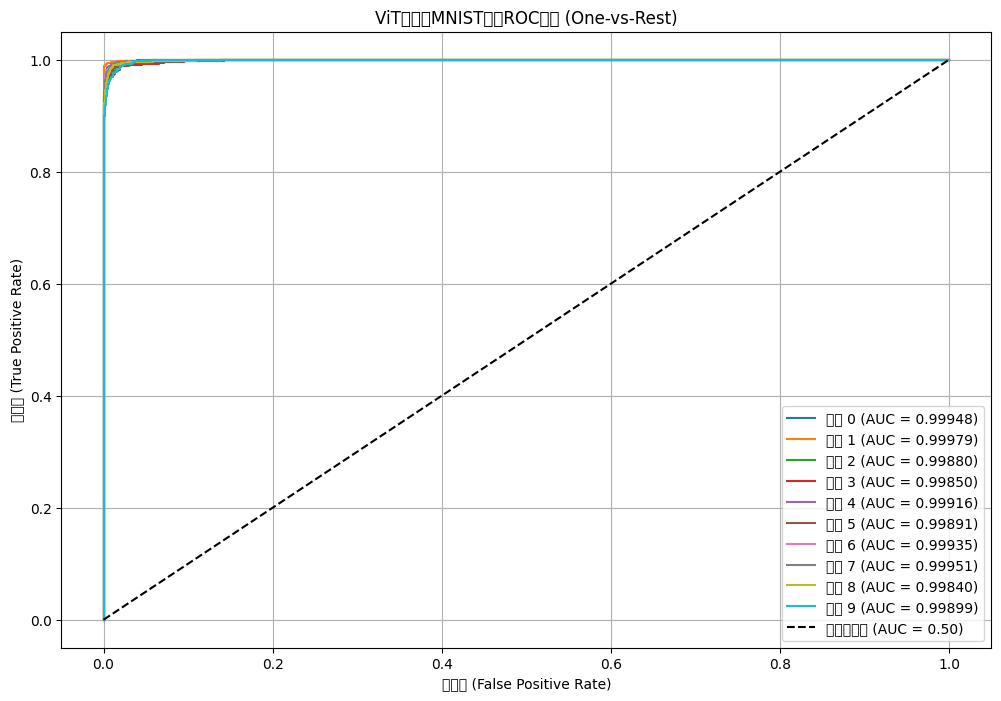

/Users/sunnychen/PycharmProjects/DeepLearningStudy/.venv/lib/python3.13/site-packages/IPython/core/pylabtools.py:170: UserWarning: Glyph 30495 (\N{CJK UNIFIED IDEOGRAPH-771F}) missing from font(s) DejaVu Sans.
  fig.canvas.print_figure(bytes_io, **kw)
/Users/sunnychen/PycharmProjects/DeepLearningStudy/.venv/lib/python3.13/site-packages/IPython/core/pylabtools.py:170: UserWarning: Glyph 27491 (\N{CJK UNIFIED IDEOGRAPH-6B63}) missing from font(s) DejaVu Sans.
  fig.canvas.print_figure(bytes_io, **kw)
/Users/sunnychen/PycharmProjects/DeepLearningStudy/.venv/lib/python3.13/site-packages/IPython/core/pylabtools.py:170: UserWarning: Glyph 29575 (\N{CJK UNIFIED IDEOGRAPH-7387}) missing from font(s) DejaVu Sans.
  fig.canvas.print_figure(bytes_io, **kw)
/Users/sunnychen/PycharmProjects/DeepLearningStudy/.venv/lib/python3.13/site-packages/IPython/core/pylabtools.py:170: UserWarning: Glyph 27169 (\N{CJK UNIFIED IDEOGRAPH-6A21}) missing from font(s) DejaVu Sans.
  fig.canvas.print_figure(bytes_io

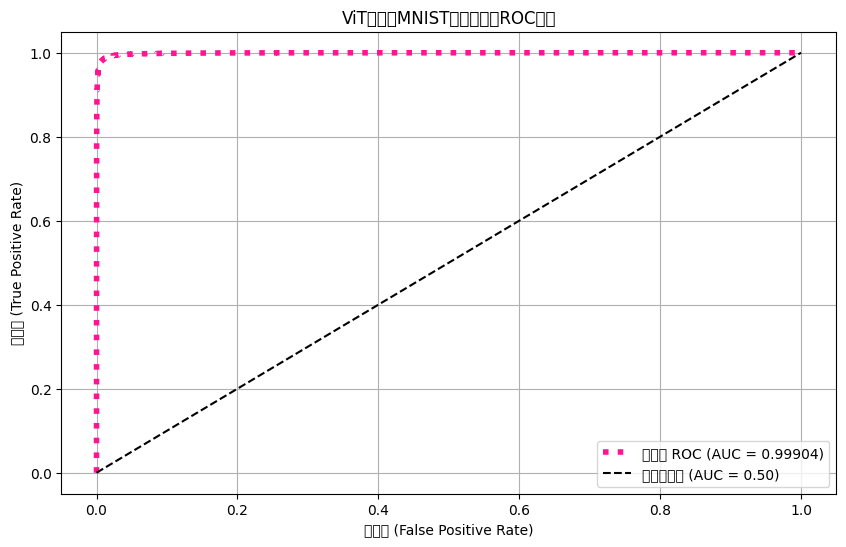

微平均AUC: 0.99904


In [12]:
# ROC曲线绘制
import numpy as np
from sklearn.metrics import roc_curve, auc
from sklearn.preprocessing import label_binarize
import matplotlib.pyplot as plt

model.eval()
all_labels = []
all_probs = []

with torch.no_grad():
    for images, labels in tqdm(test_loader, desc="收集ROC数据"):
        output = model(images)
        # 应用 softmax 获取概率
        probs = F.softmax(output, dim=1)
        
        all_labels.append(labels.cpu().numpy())
        all_probs.append(probs.cpu().numpy())

# 将所有批次的数据连接起来
all_labels = np.concatenate(all_labels)
all_probs = np.concatenate(all_probs)

# 绘制 ROC 曲线
plt.figure(figsize=(12, 8))

# 为每个类别绘制 ROC 曲线
for i in range(num_classes):
    # 将当前类别视为正类 (1)，其他类别为负类 (0)
    binary_labels = (all_labels == i).astype(int)
    class_probs = all_probs[:, i] # 获取当前类别的预测概率

    fpr, tpr, thresholds = roc_curve(binary_labels, class_probs)
    roc_auc = auc(fpr, tpr)

    plt.plot(fpr, tpr, label=f'类别 {i} (AUC = {roc_auc:.5f})')

# 绘制对角线（随机分类器）
plt.plot([0, 1], [0, 1], 'k--', label='随机分类器 (AUC = 0.50)')

plt.xlabel('假正率 (False Positive Rate)')
plt.ylabel('真正率 (True Positive Rate)')
plt.title('ViT模型在MNIST上的ROC曲线 (One-vs-Rest)')
plt.legend(loc='lower right')
plt.grid(True)
plt.show()

# 计算并绘制微平均 ROC 曲线
# 将多分类标签转换为二值化矩阵
binarized_labels = label_binarize(all_labels, classes=range(num_classes))

# 计算微平均 ROC 曲线和 AUC
fpr_micro, tpr_micro, _ = roc_curve(binarized_labels.ravel(), all_probs.ravel())
roc_auc_micro = auc(fpr_micro, tpr_micro)

plt.figure(figsize=(10, 6))
plt.plot(fpr_micro, tpr_micro, 
         label=f'微平均 ROC (AUC = {roc_auc_micro:.5f})', 
         color='deeppink', linestyle=':', linewidth=4)
plt.plot([0, 1], [0, 1], 'k--', label='随机分类器 (AUC = 0.50)')
plt.xlabel('假正率 (False Positive Rate)')
plt.ylabel('真正率 (True Positive Rate)')
plt.title('ViT模型在MNIST上的微平均ROC曲线')
plt.legend(loc='lower right')
plt.grid(True)
plt.show()

print(f"微平均AUC: {roc_auc_micro:.5f}")